In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [13]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from netrep.metrics import LinearMetric
from netrep.metrics import GaussianStochasticMetric
from netrep.metrics import LinearCKA

import sys
sys.path.insert(0,'../src')

# packages
import analysis as analysis
import activations as activations

In [3]:
# constant paths
rl_model_activations_path = "../data/activations_walker/walker_rl"
rl_hooks_path = rl_model_activations_path + "/hook_dict.npy"
rl_kinematics_path = rl_model_activations_path + "/kinematics_dict.npy"

bc_nonoise_model_activations_path = "../data/activations_walker/walker_nonoise_bcmodel_stochastic"
bc_nonoise_hooks_path = bc_nonoise_model_activations_path + "/hook_dict.npy"
bc_nonoise_kinematics_path = bc_nonoise_model_activations_path + "/kinematics_dict.npy"

bc_actnoise005_model_activations_path = "../data/activations_walker/walker_actnoise005_bcmodel_stochastic"
bc_actnoise005_hooks_path = bc_actnoise005_model_activations_path + "/hook_dict.npy"
bc_actnoise005_kinematics_path = bc_actnoise005_model_activations_path + "/kinematics_dict.npy"

bc_actnoise010_model_activations_path = "../data/activations_walker/walker_actnoise010_bcmodel_stochastic"
bc_actnoise010_hooks_path = bc_actnoise010_model_activations_path + "/hook_dict.npy"
bc_actnoise010_kinematics_path = bc_actnoise010_model_activations_path + "/kinematics_dict.npy"

bc_actnoise020_model_activations_path = "../data/activations_walker/walker_actnoise020_bcmodel_stochastic"
bc_actnoise020_hooks_path = bc_actnoise020_model_activations_path + "/hook_dict.npy"
bc_actnoise020_kinematics_path = bc_actnoise020_model_activations_path + "/kinematics_dict.npy"

bc_actnoise040_model_activations_path = "../data/activations_walker/walker_actnoise040_bcmodel_stochastic"
bc_actnoise040_hooks_path = bc_actnoise040_model_activations_path + "/hook_dict.npy"
bc_actnoise040_kinematics_path = bc_actnoise040_model_activations_path + "/kinematics_dict.npy"

bc_actnoise080_model_activations_path = "../data/activations_walker/walker_actnoise080_bcmodel_stochastic"
bc_actnoise080_hooks_path = bc_actnoise080_model_activations_path + "/hook_dict.npy"
bc_actnoise080_kinematics_path = bc_actnoise080_model_activations_path + "/kinematics_dict.npy"

bc_actnoise160_model_activations_path = "../data/activations_walker/walker_actnoise160_bcmodel_stochastic"
bc_actnoise160_hooks_path = bc_actnoise160_model_activations_path + "/hook_dict.npy"
bc_actnoise160_kinematics_path = bc_actnoise160_model_activations_path + "/kinematics_dict.npy"

In [4]:
# load hook data
rl_hook_dict = activations.load_hook_dict(rl_hooks_path)

bc_nonoise_hook_dict = activations.load_hook_dict(bc_nonoise_hooks_path)
bc_actnoise005_hook_dict = activations.load_hook_dict(bc_actnoise005_hooks_path)
bc_actnoise010_hook_dict = activations.load_hook_dict(bc_actnoise010_hooks_path)
bc_actnoise020_hook_dict = activations.load_hook_dict(bc_actnoise020_hooks_path)
bc_actnoise040_hook_dict = activations.load_hook_dict(bc_actnoise040_hooks_path)
bc_actnoise080_hook_dict = activations.load_hook_dict(bc_actnoise080_hooks_path)
bc_actnoise160_hook_dict = activations.load_hook_dict(bc_actnoise160_hooks_path)

# load kinematics data
rl_kinematics_dict = np.load(rl_kinematics_path, allow_pickle=True).item()

bc_nonoise_kinematics_dict = np.load(bc_nonoise_kinematics_path, allow_pickle=True).item()
bc_actnoise005_kinematics_dict = np.load(bc_actnoise005_kinematics_path, allow_pickle=True).item()
bc_actnoise010_kinematics_dict = np.load(bc_actnoise010_kinematics_path, allow_pickle=True).item()
bc_actnoise020_kinematics_dict = np.load(bc_actnoise020_kinematics_path, allow_pickle=True).item()
bc_actnoise040_kinematics_dict = np.load(bc_actnoise040_kinematics_path, allow_pickle=True).item()
bc_actnoise080_kinematics_dict = np.load(bc_actnoise080_kinematics_path, allow_pickle=True).item()
bc_actnoise160_kinematics_dict = np.load(bc_actnoise160_kinematics_path, allow_pickle=True).item()


In [5]:
rl_hook_dict['linear1'].shape

(100000, 1024)

In [6]:
bc_nonoise_hook_dict['linear1'].shape

(100000, 1024)

In [7]:
# from netrep.metrics import LinearMetric
# from netrep.metrics import GaussianStochasticMetric

# Rotationally invariant metric (fully regularized).
proc_metric = LinearMetric(alpha=1.0, center_columns=True)

# Linearly invariant metric (no regularization).
cca_metric = LinearMetric(alpha=0.0, center_columns=True)

In [8]:
# make directory for plots
if not os.path.exists('viz'):
    os.makedirs('viz')

In [14]:
def pairwise_comparison(loaded_hook_dict, loaded_hook_dict2, save_path='viz/test_activations_compare.png'):
    comparison_dict = {'activation_1': [],
                 'activation_2': [],
                 'metric': []}
    vmin = 0
    vmax = 1
    # get combinations between activations
    for activation1 in loaded_hook_dict.keys():
        for activation2 in loaded_hook_dict2.keys():
            #change here for metric swap
            proc_metric = LinearCKA(center_columns=True)
            proc_metric.fit(loaded_hook_dict[activation1], loaded_hook_dict2[activation2])
            dist = proc_metric.score(loaded_hook_dict[activation1], loaded_hook_dict2[activation2])
            
            if vmin < dist:
                vmin = dist
            if dist > vmax:
                vmax = dist

            comparison_dict['metric'].append(dist)
            comparison_dict['activation_1'].append(activation1)
            comparison_dict['activation_2'].append(activation2)

    df_c = pd.DataFrame(comparison_dict).pivot('activation_1', 'activation_2', 'metric')
    # force bar to be between 0 and 1
    plot_c = sns.heatmap(df_c, cbar_kws={'label': 'Representational similarity (METRIC NAME)'}, cmap='Blues', vmin=vmin, vmax=vmax)
    plt.savefig(save_path)

In [17]:
pairwise_comparison(rl_hook_dict, bc_nonoise_hook_dict)


: 

: 

In [14]:
cka(rl_hook_dict['linear2'], bc_nonoise_hook_dict['linear1'])

0.010654018

{'activation_1': ['linear1', 'linear1', 'linear1', 'linear1', 'linear2', 'linear2', 'linear2', 'linear2', 'mean_linear', 'mean_linear', 'mean_linear', 'mean_linear', 'log_std_linear', 'log_std_linear', 'log_std_linear', 'log_std_linear'], 'activation_2': ['linear1', 'linear2', 'mean_linear', 'log_std_linear', 'linear1', 'linear2', 'mean_linear', 'log_std_linear', 'linear1', 'linear2', 'mean_linear', 'log_std_linear', 'linear1', 'linear2', 'mean_linear', 'log_std_linear'], 'cka': [0.008982775, 0.035622597, 0.009563852, 0.04414229, 0.010654018, 0.055544358, 0.01110585, 0.06997871, 0.001361852, 0.003259884, 0.00087083486, 0.0034503369, 0.004529852, 0.017933521, 0.006707722, 0.022990964]}
activation_2     linear1   linear2  log_std_linear  mean_linear
activation_1                                                   
linear1         0.008983  0.035623        0.044142     0.009564
linear2         0.010654  0.055544        0.069979     0.011106
log_std_linear  0.004530  0.017934        0.022991

<Axes: xlabel='activation_2', ylabel='activation_1'>

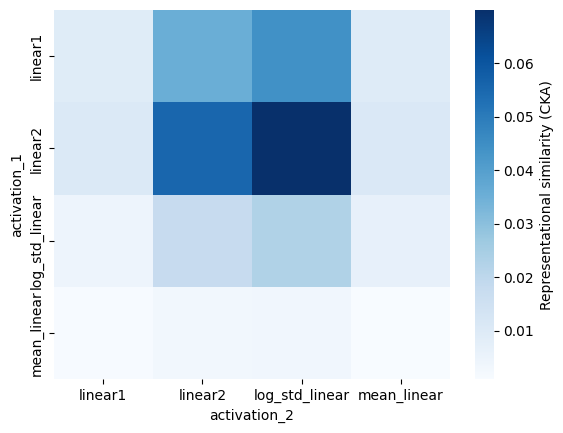

In [6]:
# cka between rl and bc
analysis.plot_cka_activations_between_models(rl_hook_dict, bc_nonoise_hook_dict, save_path='viz/rl_bc_nonoise_cka.png')

activation_2     linear1   linear2  log_std_linear  mean_linear
activation_1                                                   
linear1         1.000000  0.564075        0.392656     0.383287
linear2         0.564075  1.000000        0.159967     0.207423
log_std_linear  0.392656  0.159967        1.000000     0.276243
mean_linear     0.383287  0.207423        0.276243     1.000000


<Axes: xlabel='activation_2', ylabel='activation_1'>

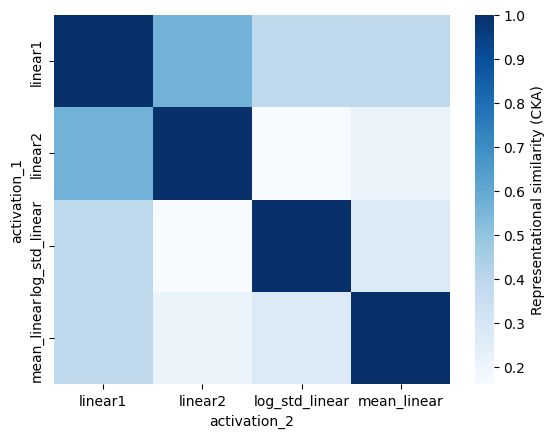

In [18]:
# cka between rl layers
analysis.plot_cka_activations(rl_hook_dict, save_path='viz/rl_cka.png')

<Axes: xlabel='activation_2', ylabel='activation_1'>

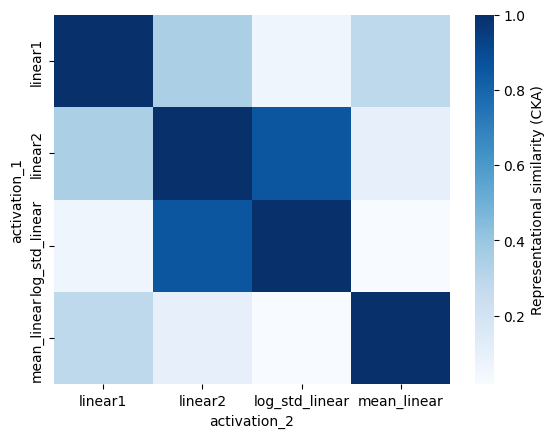

In [16]:
#cka between bc layers w/ no noise
analysis.plot_cka_activations(bc_nonoise_hook_dict, save_path='viz/bc_cka.png')

<Axes: xlabel='activation_2', ylabel='activation_1'>

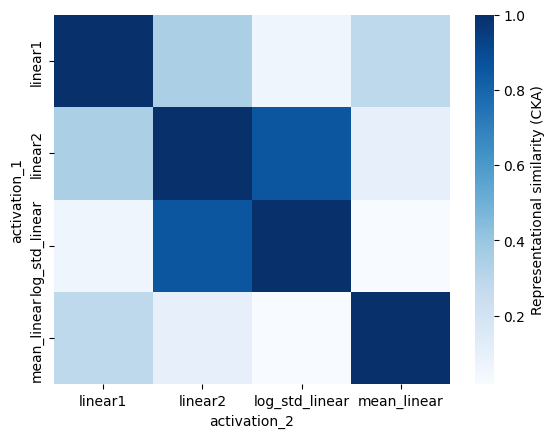

In [10]:
#cka between bc layers w/ 80 noise
analysis.plot_cka_activations(bc_nonoise_hook_dict, save_path='viz/bc80_cka.png')

<AxesSubplot:xlabel='activation', ylabel='kinematic_feature'>

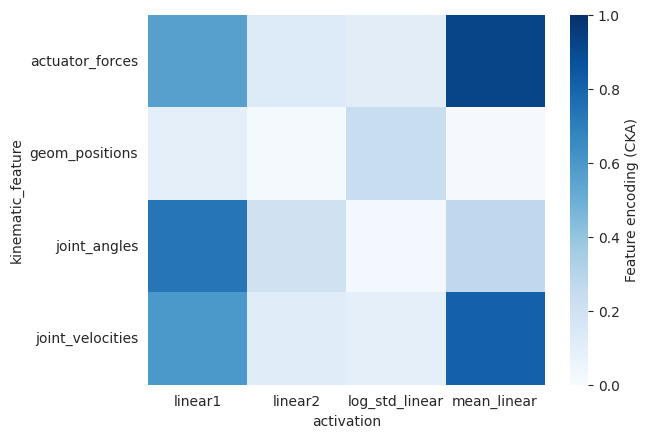

In [12]:
# cka between rl agent and rl kinematics
analysis.plot_cka_kinematics(rl_hook_dict, rl_kinematics_dict, save_path='pix/rl_kinematics_cka.png')

In [13]:
noise_levels = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6]
noise_hook_dicts = [bc_actnoise005_hook_dict, bc_actnoise010_hook_dict, bc_actnoise020_hook_dict, bc_actnoise040_hook_dict, bc_actnoise080_hook_dict, bc_actnoise160_hook_dict]
kinematics_hook_dicts = [bc_actnoise005_kinematics_dict, bc_actnoise010_kinematics_dict, bc_actnoise020_kinematics_dict, bc_actnoise040_kinematics_dict, bc_actnoise080_kinematics_dict, bc_actnoise160_kinematics_dict]

for noise_level, noise_hook_dict, noise_kinematics_dict in zip(noise_levels, noise_hook_dicts, kinematics_hook_dicts):
    # plot cka between rl and bc
    analysis.plot_cka_activations_between_models(rl_hook_dict, noise_hook_dict, save_path=f'pix/rl_bc_actnoise{noise_level}_cka.png')
    # clear the plot
    plt.clf()

    # plot cka between bc layers
    analysis.plot_cka_activations(noise_hook_dict, save_path=f'pix/bc_actnoise{noise_level}_cka.png')
    # clear the plot
    plt.clf()

    # plot cka between bc agent and bc kinematics
    analysis.plot_cka_kinematics(noise_hook_dict, noise_kinematics_dict, save_path=f'pix/bc_actnoise{noise_level}_kinematics_cka.png')
    # clear the plot
    plt.clf()


<Figure size 640x480 with 0 Axes>

In [14]:
import pandas as pd
import seaborn as sns


def pairwise_comparison(loaded_hook_dict, loaded_hook_dict2, save_path='viz/test_activations_compare.png'):
    comparison_dict = {'activation_1': [],
                 'activation_2': [],
                 'metric': []}
    vmin = 0
    vmax = 1
    # get combinations between activations
    for activation1 in loaded_hook_dict.keys():
        for activation2 in loaded_hook_dict2.keys():
            #change here for metric swap
            proc_metric = LinearMetric(alpha=1.0, center_columns=True)
            proc_metric.fit(loaded_hook_dict[activation1], loaded_hook_dict2[activation2])
            dist = proc_metric.score(loaded_hook_dict[activation1], loaded_hook_dict2[activation2])
            
            if vmin < dist:
                vmin = dist
            if dist > vmax:
                vmax = dist

            comparison_dict['metric'].append(dist)
            comparison_dict['activation_1'].append(activation1)
            comparison_dict['activation_2'].append(activation2)

    df_c = pd.DataFrame(comparison_dict).pivot('activation_1', 'activation_2', 'metric')
    # force bar to be between 0 and 1
    plot_c = sns.heatmap(df_c, cbar_kws={'label': 'Representational similarity (METRIC NAME)'}, cmap='Blues', vmin=vmin, vmax=vmax)
    plt.savefig(save_path)


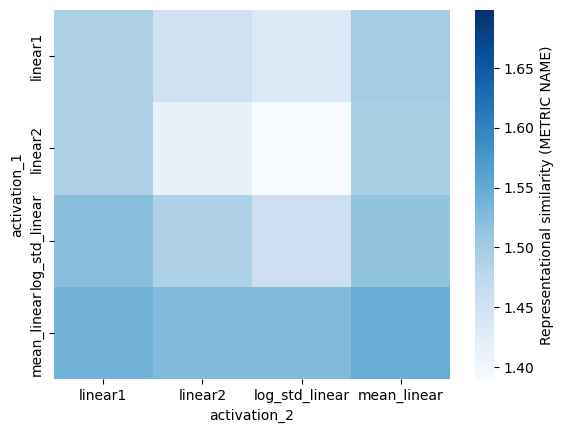

In [15]:
pairwise_comparison(rl_hook_dict, bc_nonoise_hook_dict)